## Programming Assignment 3

### Introduction 

This assignment's purpose is to analyze how multiple search algorithms perform when given a large number of problems.

Our goal is to set-up, observe and analyze how the hill climbing, hill climbing with a random restart, and simulated annealing algorithms perform when solving a large quantity of 8-puzzle and 8-queen problems.

## Theoretical Background

This assignment analayses the use of search algorithms for non-clasical problems. The algorithms used for this are:
* Hill Climbing (steepest-ascent)
* Hill Climbing (first-choice variants)
* Hill Climbing (random restart)
* Simulated Annealing


#### Hill Climbing Algorithm
The **hill climbing algorithm** is a local search algorithm that saves a small number of nodes in memory and generates new nodes based on the path which leads to a higher value (steep-ascent). This search algorithm is susceptible to getting "stuck" in local maxima which can lead to unoptimal solutions.

A different approach to this algorithm is the **first-choice hill climbing** which adds a stochastic element by generating successors randomly until one better than the current state is found. 

**Random-restart hill climbing** runs a series of hill climbing searches from randomly generated states until a goal is found. Since each hill climbing algorithm has a fixed probability of finding a goal, this approach has a probability of finding a goal that approaches 1.


#### Simulated Annealing
**Simulated Annealing** is an algorithm similar to hill climbing, except it avoids getting stuck on a local maximum by allowing the search to make "bad moves" more often at the start, and reducing the probability of committing more later on. This should make it optimal, if its given an appropriate cooling schedule.

Problem & Node

In [1]:
"""Provides some utilities widely used by other modules"""

import bisect
import collections
import collections.abc
import functools
import heapq
import operator
import os.path
import random
from itertools import chain, combinations
from statistics import mean

import numpy as np


# ______________________________________________________________________________
# Functions on Sequences and Iterables


def sequence(iterable):
    """Converts iterable to sequence, if it is not already one."""
    return iterable if isinstance(iterable, collections.abc.Sequence) else tuple([iterable])


def remove_all(item, seq):
    """Return a copy of seq (or string) with all occurrences of item removed."""
    if isinstance(seq, str):
        return seq.replace(item, '')
    elif isinstance(seq, set):
        rest = seq.copy()
        rest.remove(item)
        return rest
    else:
        return [x for x in seq if x != item]


def unique(seq):
    """Remove duplicate elements from seq. Assumes hashable elements."""
    return list(set(seq))


def count(seq):
    """Count the number of items in sequence that are interpreted as true."""
    return sum(map(bool, seq))


def multimap(items):
    """Given (key, val) pairs, return {key: [val, ....], ...}."""
    result = collections.defaultdict(list)
    for (key, val) in items:
        result[key].append(val)
    return dict(result)


def multimap_items(mmap):
    """Yield all (key, val) pairs stored in the multimap."""
    for (key, vals) in mmap.items():
        for val in vals:
            yield key, val


def product(numbers):
    """Return the product of the numbers, e.g. product([2, 3, 10]) == 60"""
    result = 1
    for x in numbers:
        result *= x
    return result


def first(iterable, default=None):
    """Return the first element of an iterable; or default."""
    return next(iter(iterable), default)


def is_in(elt, seq):
    """Similar to (elt in seq), but compares with 'is', not '=='."""
    return any(x is elt for x in seq)


def mode(data):
    """Return the most common data item. If there are ties, return any one of them."""
    [(item, count)] = collections.Counter(data).most_common(1)
    return item


def power_set(iterable):
    """power_set([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s) + 1)))[1:]


def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}


def flatten(seqs):
    return sum(seqs, [])


# ______________________________________________________________________________
# argmin and argmax

identity = lambda x: x


def argmin_random_tie(seq, key=identity):
    """Return a minimum element of seq; break ties at random."""
    return min(shuffled(seq), key=key)


def argmax_random_tie(seq, key=identity):
    """Return an element with highest fn(seq[i]) score; break ties at random."""
    return max(shuffled(seq), key=key)


def shuffled(iterable):
    """Randomly shuffle a copy of iterable."""
    items = list(iterable)
    random.shuffle(items)
    return items


# ______________________________________________________________________________
# Statistical and mathematical functions


def histogram(values, mode=0, bin_function=None):
    """Return a list of (value, count) pairs, summarizing the input values.
    Sorted by increasing value, or if mode=1, by decreasing count.
    If bin_function is given, map it over values first."""
    if bin_function:
        values = map(bin_function, values)

    bins = {}
    for val in values:
        bins[val] = bins.get(val, 0) + 1

    if mode:
        return sorted(list(bins.items()), key=lambda x: (x[1], x[0]), reverse=True)
    else:
        return sorted(bins.items())


def dot_product(x, y):
    """Return the sum of the element-wise product of vectors x and y."""
    return sum(_x * _y for _x, _y in zip(x, y))


def element_wise_product(x, y):
    """Return vector as an element-wise product of vectors x and y."""
    assert len(x) == len(y)
    return np.multiply(x, y)


def matrix_multiplication(x, *y):
    """Return a matrix as a matrix-multiplication of x and arbitrary number of matrices *y."""

    result = x
    for _y in y:
        result = np.matmul(result, _y)

    return result


def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))


def scalar_vector_product(x, y):
    """Return vector as a product of a scalar and a vector"""
    return np.multiply(x, y)


def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)


def weighted_sample_with_replacement(n, seq, weights):
    """Pick n samples from seq at random, with replacement, with the
    probability of each element in proportion to its corresponding
    weight."""
    sample = weighted_sampler(seq, weights)
    return [sample() for _ in range(n)]


def weighted_sampler(seq, weights):
    """Return a random-sample function that picks from seq weighted by weights."""
    totals = []
    for w in weights:
        totals.append(w + totals[-1] if totals else w)
    return lambda: seq[bisect.bisect(totals, random.uniform(0, totals[-1]))]


def weighted_choice(choices):
    """A weighted version of random.choice"""
    # NOTE: should be replaced by random.choices if we port to Python 3.6

    total = sum(w for _, w in choices)
    r = random.uniform(0, total)
    upto = 0
    for c, w in choices:
        if upto + w >= r:
            return c, w
        upto += w


def rounder(numbers, d=4):
    """Round a single number, or sequence of numbers, to d decimal places."""
    if isinstance(numbers, (int, float)):
        return round(numbers, d)
    else:
        constructor = type(numbers)  # Can be list, set, tuple, etc.
        return constructor(rounder(n, d) for n in numbers)


def num_or_str(x):  # TODO: rename as `atom`
    """The argument is a string; convert to a number if possible, or strip it."""
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return str(x).strip()


def euclidean_distance(x, y):
    return np.sqrt(sum((_x - _y) ** 2 for _x, _y in zip(x, y)))


def manhattan_distance(x, y):
    return sum(abs(_x - _y) for _x, _y in zip(x, y))


def hamming_distance(x, y):
    return sum(_x != _y for _x, _y in zip(x, y))


def cross_entropy_loss(x, y):
    return (-1.0 / len(x)) * sum(_x * np.log(_y) + (1 - _x) * np.log(1 - _y) for _x, _y in zip(x, y))


def mean_squared_error_loss(x, y):
    return (1.0 / len(x)) * sum((_x - _y) ** 2 for _x, _y in zip(x, y))


def rms_error(x, y):
    return np.sqrt(ms_error(x, y))


def ms_error(x, y):
    return mean((_x - _y) ** 2 for _x, _y in zip(x, y))


def mean_error(x, y):
    return mean(abs(_x - _y) for _x, _y in zip(x, y))


def mean_boolean_error(x, y):
    return mean(_x != _y for _x, _y in zip(x, y))


def normalize(dist):
    """Multiply each number by a constant such that the sum is 1.0"""
    if isinstance(dist, dict):
        total = sum(dist.values())
        for key in dist:
            dist[key] = dist[key] / total
            assert 0 <= dist[key] <= 1  # probabilities must be between 0 and 1
        return dist
    total = sum(dist)
    return [(n / total) for n in dist]


def random_weights(min_value, max_value, num_weights):
    return [random.uniform(min_value, max_value) for _ in range(num_weights)]


def sigmoid(x):
    """Return activation value of x with sigmoid function."""
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(value):
    return value * (1 - value)


def elu(x, alpha=0.01):
    return x if x > 0 else alpha * (np.exp(x) - 1)


def elu_derivative(value, alpha=0.01):
    return 1 if value > 0 else alpha * np.exp(value)


def tanh(x):
    return np.tanh(x)


def tanh_derivative(value):
    return 1 - (value ** 2)


def leaky_relu(x, alpha=0.01):
    return x if x > 0 else alpha * x


def leaky_relu_derivative(value, alpha=0.01):
    return 1 if value > 0 else alpha


def relu(x):
    return max(0, x)


def relu_derivative(value):
    return 1 if value > 0 else 0


def step(x):
    """Return activation value of x with sign function"""
    return 1 if x >= 0 else 0


def gaussian(mean, st_dev, x):
    """Given the mean and standard deviation of a distribution, it returns the probability of x."""
    return 1 / (np.sqrt(2 * np.pi) * st_dev) * np.e ** (-0.5 * (float(x - mean) / st_dev) ** 2)


def linear_kernel(x, y=None):
    if y is None:
        y = x
    return np.dot(x, y.T)


def polynomial_kernel(x, y=None, degree=2.0):
    if y is None:
        y = x
    return (1.0 + np.dot(x, y.T)) ** degree


def rbf_kernel(x, y=None, gamma=None):
    """Radial-basis function kernel (aka squared-exponential kernel)."""
    if y is None:
        y = x
    if gamma is None:
        gamma = 1.0 / x.shape[1]  # 1.0 / n_features
    return np.exp(-gamma * (-2.0 * np.dot(x, y.T) +
                            np.sum(x * x, axis=1).reshape((-1, 1)) + np.sum(y * y, axis=1).reshape((1, -1))))


# ______________________________________________________________________________
# Grid Functions


orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)


def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)


def turn_left(heading):
    return turn_heading(heading, LEFT)


def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return np.hypot((xA - xB), (yA - yB))


def distance_squared(a, b):
    """The square of the distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return (xA - xB) ** 2 + (yA - yB) ** 2


# ______________________________________________________________________________
# Misc Functions

class injection:
    """Dependency injection of temporary values for global functions/classes/etc.
    E.g., `with injection(DataBase=MockDataBase): ...`"""

    def __init__(self, **kwds):
        self.new = kwds

    def __enter__(self):
        self.old = {v: globals()[v] for v in self.new}
        globals().update(self.new)

    def __exit__(self, type, value, traceback):
        globals().update(self.old)


def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn


def name(obj):
    """Try to find some reasonable name for the object."""
    return (getattr(obj, 'name', 0) or getattr(obj, '__name__', 0) or
            getattr(getattr(obj, '__class__', 0), '__name__', 0) or
            str(obj))


def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')


def issequence(x):
    """Is x a sequence?"""
    return isinstance(x, collections.abc.Sequence)


def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '{:.2f}'.
    (If you want different formats in different columns,
    don't use print_table.) sep is the separator between columns."""
    justs = ['rjust' if isnumber(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if isnumber(x) else x for x in row]
             for row in table]

    sizes = list(map(lambda seq: max(map(len, seq)), list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))


def open_data(name, mode='r'):
    aima_root = os.path.dirname(__file__)
    aima_file = os.path.join(aima_root, *['aima-data', name])

    return open(aima_file, mode=mode)


def failure_test(algorithm, tests):
    """Grades the given algorithm based on how many tests it passes.
    Most algorithms have arbitrary output on correct execution, which is difficult
    to check for correctness. On the other hand, a lot of algorithms output something
    particular on fail (for example, False, or None).
    tests is a list with each element in the form: (values, failure_output)."""
    return mean(int(algorithm(x) != y) for x, y in tests)


# ______________________________________________________________________________
# Expressions

# See https://docs.python.org/3/reference/expressions.html#operator-precedence
# See https://docs.python.org/3/reference/datamodel.html#special-method-names

class Expr:
    """A mathematical expression with an operator and 0 or more arguments.
    op is a str like '+' or 'sin'; args are Expressions.
    Expr('x') or Symbol('x') creates a symbol (a nullary Expr).
    Expr('-', x) creates a unary; Expr('+', x, 1) creates a binary."""

    def __init__(self, op, *args):
        self.op = str(op)
        self.args = args

    # Operator overloads
    def __neg__(self):
        return Expr('-', self)

    def __pos__(self):
        return Expr('+', self)

    def __invert__(self):
        return Expr('~', self)

    def __add__(self, rhs):
        return Expr('+', self, rhs)

    def __sub__(self, rhs):
        return Expr('-', self, rhs)

    def __mul__(self, rhs):
        return Expr('*', self, rhs)

    def __pow__(self, rhs):
        return Expr('**', self, rhs)

    def __mod__(self, rhs):
        return Expr('%', self, rhs)

    def __and__(self, rhs):
        return Expr('&', self, rhs)

    def __xor__(self, rhs):
        return Expr('^', self, rhs)

    def __rshift__(self, rhs):
        return Expr('>>', self, rhs)

    def __lshift__(self, rhs):
        return Expr('<<', self, rhs)

    def __truediv__(self, rhs):
        return Expr('/', self, rhs)

    def __floordiv__(self, rhs):
        return Expr('//', self, rhs)

    def __matmul__(self, rhs):
        return Expr('@', self, rhs)

    def __or__(self, rhs):
        """Allow both P | Q, and P |'==>'| Q."""
        if isinstance(rhs, Expression):
            return Expr('|', self, rhs)
        else:
            return PartialExpr(rhs, self)

    # Reverse operator overloads
    def __radd__(self, lhs):
        return Expr('+', lhs, self)

    def __rsub__(self, lhs):
        return Expr('-', lhs, self)

    def __rmul__(self, lhs):
        return Expr('*', lhs, self)

    def __rdiv__(self, lhs):
        return Expr('/', lhs, self)

    def __rpow__(self, lhs):
        return Expr('**', lhs, self)

    def __rmod__(self, lhs):
        return Expr('%', lhs, self)

    def __rand__(self, lhs):
        return Expr('&', lhs, self)

    def __rxor__(self, lhs):
        return Expr('^', lhs, self)

    def __ror__(self, lhs):
        return Expr('|', lhs, self)

    def __rrshift__(self, lhs):
        return Expr('>>', lhs, self)

    def __rlshift__(self, lhs):
        return Expr('<<', lhs, self)

    def __rtruediv__(self, lhs):
        return Expr('/', lhs, self)

    def __rfloordiv__(self, lhs):
        return Expr('//', lhs, self)

    def __rmatmul__(self, lhs):
        return Expr('@', lhs, self)

    def __call__(self, *args):
        """Call: if 'f' is a Symbol, then f(0) == Expr('f', 0)."""
        if self.args:
            raise ValueError('Can only do a call for a Symbol, not an Expr')
        else:
            return Expr(self.op, *args)

    # Equality and repr
    def __eq__(self, other):
        """x == y' evaluates to True or False; does not build an Expr."""
        return isinstance(other, Expr) and self.op == other.op and self.args == other.args

    def __lt__(self, other):
        return isinstance(other, Expr) and str(self) < str(other)

    def __hash__(self):
        return hash(self.op) ^ hash(self.args)

    def __repr__(self):
        op = self.op
        args = [str(arg) for arg in self.args]
        if op.isidentifier():  # f(x) or f(x, y)
            return '{}({})'.format(op, ', '.join(args)) if args else op
        elif len(args) == 1:  # -x or -(x + 1)
            return op + args[0]
        else:  # (x - y)
            opp = (' ' + op + ' ')
            return '(' + opp.join(args) + ')'


# An 'Expression' is either an Expr or a Number.
# Symbol is not an explicit type; it is any Expr with 0 args.


Number = (int, float, complex)
Expression = (Expr, Number)


def Symbol(name):
    """A Symbol is just an Expr with no args."""
    return Expr(name)


def symbols(names):
    """Return a tuple of Symbols; names is a comma/whitespace delimited str."""
    return tuple(Symbol(name) for name in names.replace(',', ' ').split())


def subexpressions(x):
    """Yield the subexpressions of an Expression (including x itself)."""
    yield x
    if isinstance(x, Expr):
        for arg in x.args:
            yield from subexpressions(arg)


def arity(expression):
    """The number of sub-expressions in this expression."""
    if isinstance(expression, Expr):
        return len(expression.args)
    else:  # expression is a number
        return 0


# For operators that are not defined in Python, we allow new InfixOps:


class PartialExpr:
    """Given 'P |'==>'| Q, first form PartialExpr('==>', P), then combine with Q."""

    def __init__(self, op, lhs):
        self.op, self.lhs = op, lhs

    def __or__(self, rhs):
        return Expr(self.op, self.lhs, rhs)

    def __repr__(self):
        return "PartialExpr('{}', {})".format(self.op, self.lhs)


def expr(x):
    """Shortcut to create an Expression. x is a str in which:
    - identifiers are automatically defined as Symbols.
    - ==> is treated as an infix |'==>'|, as are <== and <=>.
    If x is already an Expression, it is returned unchanged. Example:
    >>> expr('P & Q ==> Q')
    ((P & Q) ==> Q)
    """
    return eval(expr_handle_infix_ops(x), defaultkeydict(Symbol)) if isinstance(x, str) else x


infix_ops = '==> <== <=>'.split()


def expr_handle_infix_ops(x):
    """Given a str, return a new str with ==> replaced by |'==>'|, etc.
    >>> expr_handle_infix_ops('P ==> Q')
    "P |'==>'| Q"
    """
    for op in infix_ops:
        x = x.replace(op, '|' + repr(op) + '|')
    return x


class defaultkeydict(collections.defaultdict):
    """Like defaultdict, but the default_factory is a function of the key.
    >>> d = defaultkeydict(len); d['four']
    4
    """

    def __missing__(self, key):
        self[key] = result = self.default_factory(key)
        return result


class hashabledict(dict):
    """Allows hashing by representing a dictionary as tuple of key:value pairs.
    May cause problems as the hash value may change during runtime."""

    def __hash__(self):
        return 1


# ______________________________________________________________________________
# Queues: Stack, FIFOQueue, PriorityQueue
# Stack and FIFOQueue are implemented as list and collection.deque
# PriorityQueue is implemented here


class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("Order must be either 'min' or 'max'.")

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)


# ______________________________________________________________________________
# Useful Shorthands


class Bool(int):
    """Just like `bool`, except values display as 'T' and 'F' instead of 'True' and 'False'."""
    __str__ = __repr__ = lambda self: 'T' if self else 'F'


T = Bool(True)
F = Bool(False)

In [2]:
import sys
from collections import deque

# from utils import *
import random
import math

class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)




class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        distance = 0
        for i , tile in enumerate(state):
            row,col = divmod(i,3)
            goal_row,goal_col = divmod(tile - 1 , 3)
            current = manhattan_distance((row,col),(goal_row,goal_col))
            #print(f"This is i -> {i}")
            #print(f"This is tile -> {tile}")
            #print(f"This is current -> {current}")
            distance += current
            #print(f"This is distance -> {distance}")
        return -(distance)
        
        

## 8-Puzzle Problem

In [3]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board, where one of the
    squares is a blank. A state is represented as a tuple of length 9, where  element at
    index i represents the tile number  at index i (0 if it's an empty square) """

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        """ Define goal state and initialize a problem """
        super().__init__(initial, goal)

    def find_blank_square(self, state):
        """Return the index of the blank square in a given state"""

        return state.index(0)

    def actions(self, state):
        """ Return the actions that can be executed in the given state.
        The result would be a list, since there are only four possible actions
        in any given state of the environment """

        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        index_blank_square = self.find_blank_square(state)

        if index_blank_square % 3 == 0:
            possible_actions.remove('LEFT')
        if index_blank_square < 3:
            possible_actions.remove('UP')
        if index_blank_square % 3 == 2:
            possible_actions.remove('RIGHT')
        if index_blank_square > 5:
            possible_actions.remove('DOWN')

        return possible_actions

    def result(self, state, action):
        """ Given state and action, return a new state that is the result of the action.
        Action is assumed to be a valid action in the state """

        # blank is the index of the blank square
        blank = self.find_blank_square(state)
        new_state = list(state)

        delta = {'UP': -3, 'DOWN': 3, 'LEFT': -1, 'RIGHT': 1}
        neighbor = blank + delta[action]
        new_state[blank], new_state[neighbor] = new_state[neighbor], new_state[blank]

        return tuple(new_state)

    def goal_test(self, state):
        """ Given a state, return True if state is a goal state or False, otherwise """
        return tuple(state) == self.goal

    def check_solvability(self, state):
        """ Checks if the given state is solvable """

        inversion = 0
        for i in range(len(state)):
            for j in range(i + 1, len(state)):
                if (state[i] > state[j]) and state[i] != 0 and state[j] != 0:
                    inversion += 1

        return inversion % 2 == 0

    def h(self, node):
        """ Return the heuristic value for a given state. Default heuristic function used is 
        h(n) = number of misplaced tiles """

        return sum(s != g for (s, g) in zip(tuple(node.state), self.goal))

### NQueens
use N = 8 to generate a 8Queens problem

In [4]:
class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking
    each other. A state is represented as an N-element array, where
    a value of r in the c-th entry means there is a queen at column c,
    row r, and a value of -1 means that the c-th column has not been
    filled in yet. We fill in columns left to right.
    >>> depth_first_tree_search(NQueensProblem(8))
    <Node (7, 3, 0, 2, 5, 1, 6, 4)>
    """

    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

    def h(self, node):
        """Return number of conflicting queens for a given node"""
        num_conflicts = 0
        for (r1, c1) in enumerate(node.state):
            for (r2, c2) in enumerate(node.state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)

        return num_conflicts

Generate Problems

In [5]:
def generate_puzzles(num_puzzles):
    puzzles = []
    i=0
    for i in range(num_puzzles):
        # Generate a solvable puzzle by shuffling until we get one that is solvable
        while True:
            numbers = list(range(9))
            random.shuffle(numbers)
            puzzle = EightPuzzle(numbers)
            if puzzle.check_solvability(numbers):
                puzzles.append(puzzle)
               # print("Puzzle ",i , " is: ",numbers)
                i = i+1
                break
    return puzzles

def generate_8Queens(num_boards):
    boards = []
    for i in range(num_boards):
        boards.append(NQueensProblem(8))
    return boards


## Hill-Climbing & Hill Climbing with Random Restart

In [6]:
def shuffled(iterable):
    """Randomly shuffle a copy of iterable."""
    items = list(iterable)
    random.shuffle(items)
    return items

identity = lambda x: x
def argmax_random_tie(seq, key=identity):
    """Return an element with highest fn(seq[i]) score; break ties at random."""
    return max(shuffled(seq), key=key)


def hill_climbing(problem):
    moves = 0
    """
    [Figure 4.2]
    From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better.
    """
    current = Node(problem.initial)
    while True:
        if(problem.goal_test(current.state)):
            break
        neighbors = current.expand(problem)
        moves = len(neighbors) + moves
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors, key=lambda node: problem.h(node))
        if problem.h(neighbor) <= problem.h(current):
            break
        current = neighbor
    return [moves, problem.goal_test(current.state)]

def hill_climbingRR(problem, ptype):
    moves = 0
    initial = Node(problem.initial)
    current = Node(problem.initial)
    
    while not problem.goal_test(current.state):
        neighbors = current.expand(problem)
        moves = moves + len(neighbors)
        if not neighbors:#Reshuffle
            while not neighbors and not problem.goal_test(current.state):
                if(ptype == "8-Puzzle"):
                    newPuzzle = generate_puzzles(1)
                else:#8Queens
                    newPuzzle = generate_8Queens(1)
                #set it to current
                current = Node(newPuzzle[0].initial)
                neighbors = current.expand(problem)
                moves = moves + len(neighbors)
        if problem.goal_test(current.state):
            return [moves, problem.goal_test(current.state)]
        neighbor = argmax_random_tie(neighbors, key=lambda node: problem.h(node))
        current = neighbor
        if not problem.goal_test(current.state):
            #Reshuffle the initial state
            if(ptype == "8-Puzzle"):
                newPuzzle = generate_puzzles(1)
            else:#8Queens
                newPuzzle = generate_8Queens(1)
            
            #set it to current
            current = Node(newPuzzle[0].initial)
       
    return [moves, problem.goal_test(current.state)]
                
            
        


## Simulated Annealing

In [7]:
def exp_schedule(k=20, lam=0.005, limit=100):
    """One possible schedule function for simulated annealing"""
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)

def simulated_annealing(problem, schedule=exp_schedule()):
    """[Figure 4.5] CAUTION: This differs from the pseudocode as it
    returns a state instead of a Node."""
    moves = 0
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0:
            return [moves, problem.goal_test(current.state)]
        neighbors = current.expand(problem)
        moves = moves + len(neighbors)
        if not neighbors:
            return [moves, problem.goal_test(current.state)]
        next_choice = random.choice(neighbors)
        delta_e = problem.h(next_choice) - problem.h(current)
        if delta_e > 0 or probability(np.exp(delta_e / T)):
            current = next_choice

## Solving the generated problems
Obtain the Search Cost and the Success Rate while attempting to solve the generated problems

In [8]:
# 8-puzzle generation and solving
iterations = 20
puzzles = generate_puzzles(iterations)

HCSearchCost = 0
HCSuccessRate = 0

RRSearchCost = 0
RRSuccessRate = 0

SASearchCost = 0
SASuccessRate = 0
for puzzle in puzzles:
    #print("Solution for puzzle ", i)
    solution = hill_climbing(puzzle)
    HCSearchCost = solution[0] + HCSearchCost
    if solution[1]:
        HCSuccessRate = 1 + HCSuccessRate
    
    solution = hill_climbingRR(puzzle,"8-Puzzle")
    RRSearchCost = solution[0] + RRSearchCost
    if solution[1]:
        RRSuccessRate = 1 + RRSuccessRate
    
    solution = simulated_annealing(puzzle)
    SASearchCost = solution[0] + SASearchCost
    if solution[1]:
        SASuccessRate = 1 + SASuccessRate
        
#Average the search costs and calculate the Success Rate
HCSearchCost = HCSearchCost/iterations
HCSuccessRate = (HCSuccessRate/iterations)*100

RRSearchCost = RRSearchCost/iterations
RRSuccessRate = (RRSuccessRate/iterations)*100

SASearchCost = SASearchCost/iterations
SASuccessRate = (SASuccessRate/iterations)*100


In [9]:
#8-Queen generation and solving
boards = generate_8Queens(10)

for board in boards:
    #Call Algorithms to solve
    #print(Node(board.initial))
    #print(hill_climbing(board))
    #print(hill_climbingRR(board,"8Queens"))
    simulated_annealing(board)


# Plots

Search Cost vs Optimal Solution Cost

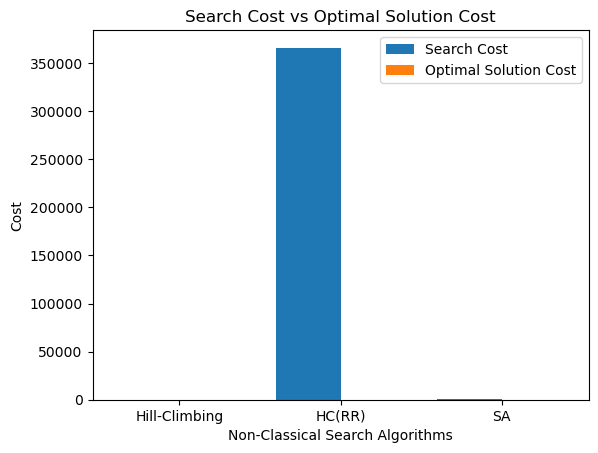

In [10]:
import matplotlib.pyplot as plt
import numpy as np

w = 0.4
# Hill Climbing, Hill Climbing (Random Restart), and Simulated Annealing
x = ["Hill-Climbing","HC(RR)","SA"]
searchCost=[HCSearchCost,RRSearchCost, SASearchCost]
optimalSolutionCost=[31,31,31] #Optimal Solution cost for 8-Queens problem is 31 moves 


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1, searchCost,w,label="Search Cost")
plt.bar(bar2, optimalSolutionCost,w,label="Optimal Solution Cost")

plt.xlabel("Non-Classical Search Algorithms")
plt.xticks(bar1+w/2, x)
plt.ylabel("Cost")
plt.title("Search Cost vs Optimal Solution Cost")
plt.legend()
plt.show()



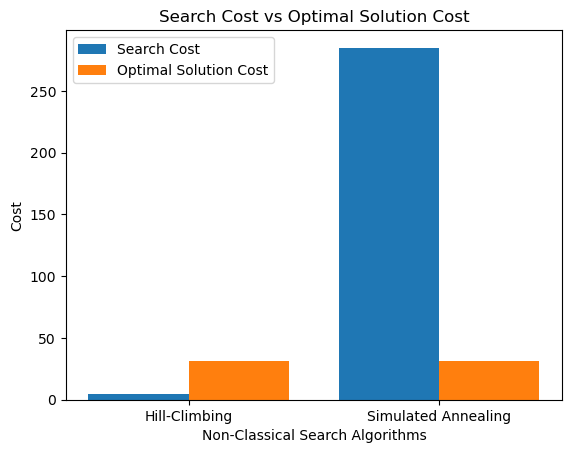

In [11]:
# Hill Climbing, and Simulated Annealing
x = ["Hill-Climbing","Simulated Annealing"]
searchCost=[HCSearchCost,SASearchCost]
optimalSolutionCost=[31,31] #Optimal Solution cost for 8-Queens problem is 31 moves 


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1, searchCost,w,label="Search Cost")
plt.bar(bar2, optimalSolutionCost,w,label="Optimal Solution Cost")

plt.xlabel("Non-Classical Search Algorithms")
plt.xticks(bar1+w/2, x)
plt.ylabel("Cost")
plt.title("Search Cost vs Optimal Solution Cost")
plt.legend()
plt.show()

Percentage of Solved Problems

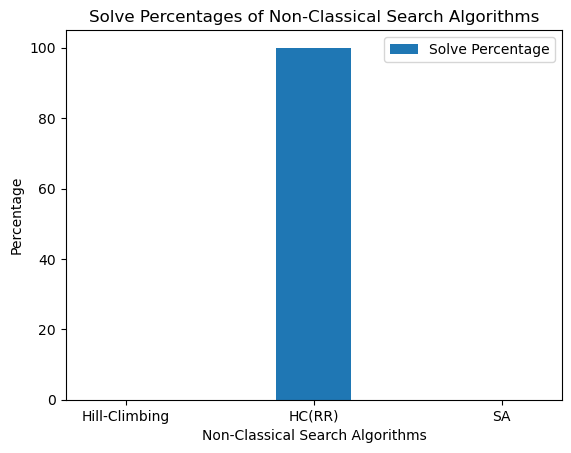

In [12]:
# Hill Climbing, Hill Climbing (Random Restart), and Simulated Annealing
x = ["Hill-Climbing","HC(RR)","SA"]

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
solvePercentage= [HCSuccessRate, RRSuccessRate, SASuccessRate]

plt.bar(bar1, solvePercentage,w,label="Solve Percentage")

plt.xlabel("Non-Classical Search Algorithms")
plt.xticks(bar1, x)
plt.ylabel("Percentage")
plt.title("Solve Percentages of Non-Classical Search Algorithms")
plt.legend()
plt.show()

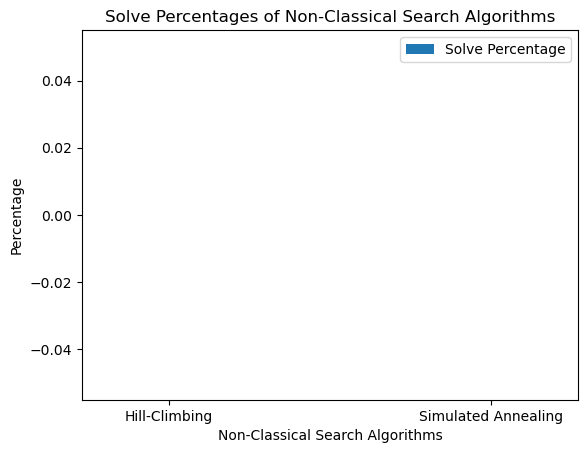

In [13]:
solvePercentage= [HCSuccessRate,SASuccessRate]

x = ["Hill-Climbing","Simulated Annealing"]
searchCost=[HCSearchCost,SASearchCost]
optimalSolutionCost=[31,31] #Optimal Solution cost for 8-Queens problem is 31 moves 


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1, solvePercentage,w,label="Solve Percentage")

plt.xlabel("Non-Classical Search Algorithms")
plt.xticks(bar1, x)
plt.ylabel("Percentage")
plt.title("Solve Percentages of Non-Classical Search Algorithms")
plt.legend()
plt.show()

# Analysis:


Analyzing the results, we can see that in the sample size of twenty 8-puzzle problems Hill-Climbing and Simulated Annealing never reached the solution once. This is because they get stuck in a plateau or on a local maximum, preventing the search algorithms from finding the correct solution. This was not the case for the Random Restart variation of Hill-Climbing as it keeps going forever, readjusting its initial state until it eventually reaches the goal state, ensuring a 100% success rate 

Because of this, the average search cost of Hill Climbing is below the optimal solution cost, as it manages to get stuck before that point.
The average search cost for simulated annealing is larger than the optimal search cost as intentionally making bad moves frees it from the plateaus or local maximums that it can encounter until the temperature drops.
Since the random restart search algorithm does not end until it finds the solution, its search cost is vastly higher than the optimal search cost.

However, when attempting to solve the 8 Queens Problem, the hill climbing and random restart search algorithms utilized are unable to complete it ever, as they cannot decide where a queen should be placed in the initial state. The simulated annealing algorithm, does not suffer from this issue as it will make a "bad" move and start placing queens.

# Conclusion

Applying different approaches to local search algorithms can improve their performance in both closer cost to the optimal cost and achieving a higher percentage of completion for a given problem.

# References

[1] S. J. Russell, P. Norvig, and E. Davis, Artificial Intelligence: A modern approach. Harlow, England: Pearson Educación, 2022.

[2] Aimacode, “Aimacode/aima-python: Python implementation of algorithms from Russell and Norvig's ‘artificial intelligence - A modern approach,’” GitHub, 2018. [Online]. Available: https://github.com/aimacode/aima-python/. [Accessed: 11-Apr-2023].

[3] J. Wolfe, “The hardest eight-puzzle instances take 31 moves to solve,” W01FE, 16-May-2009. [Online]. Available: http://w01fe.com/blog/2009/01/the-hardest-eight-puzzle-instances-take-31-moves-to-solve/. [Accessed: 14-Apr-2023]. 
